# Problem Statement

Amazon is an online e-commerce marketplace that sells a variety of products ranging from personal care, books, electronics to food

In order to give a prospective customer some idea about an available product on the marketplace amazon sends out an email to the actual buyer asking his/her feedback about the seller and product which includes a star rating (1-5) and some review text

Deriving from the Principle of Collective intelligence, Amazon product reviews is a great way to know whether a product meets the needs of a customer and what to expect when the product is delivered.

Recommending a product to a prospective customer based on product review becomes critical to maximise customer conversion and loyalty

# Objectives 

1. Classify the reviews based on their usefulness

2. Ultimately use this information to provide informed recommendations to new prospective customers 

# Data Collection

The data used in this project has been procured  from the curated dataset maintained at SNAP – 

http://jmcauley.ucsd.edu/data/amazon/

# What kind of data we are looking at?

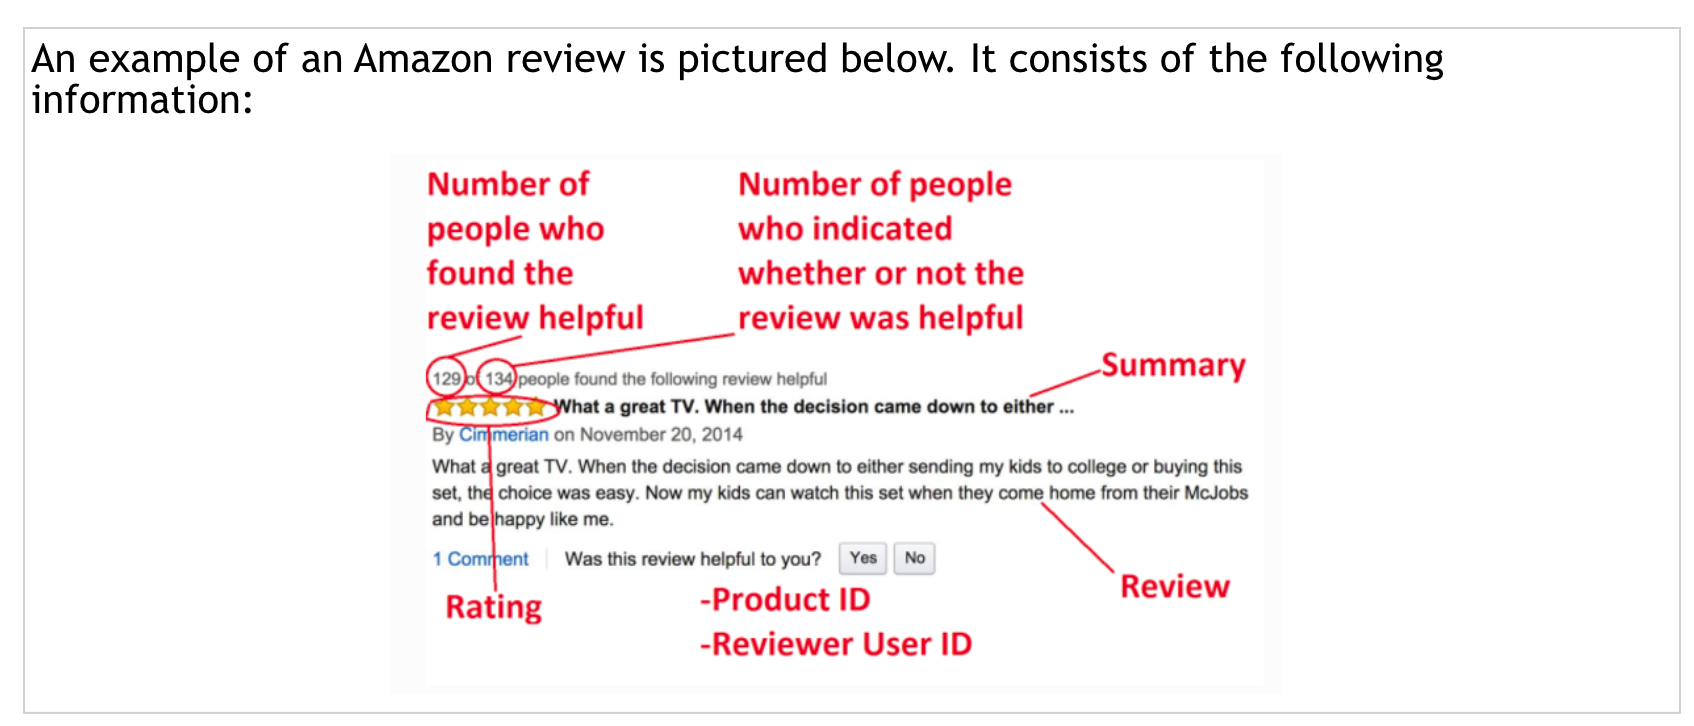

# Why this project is unique - 

The strength of this project is its generality and implementation
This is more like an end to end project for any e-commerce portal, hotel booking website, music/movie recommendation service, which captures the end users feedback in a textual form apart from some sort of star rating mechanism.


Traditionally the recommendations are driven by the explicit feedback ratings (like the 1-5 star rating) but this approach comes up with a novel approach which captures the implicit features from review text along with the actual ratings to calculate a score called average rating. 


As already mentioned, the entire project can be split into 2 main components- 

1) Predicting whether the review is helpful or not 

2) Using that information to calculate the average_rating of the product/item to make product recommendations

To tackle the problem of different scales for Predicted_Helpful(0-1), Review_Helpful(0-1) and overall rating(1-5), we have come up with weights which help in determining how to prioritize each of these quantities to calculate our final score. Finally a scaling logic has been used that translates the combination of these three quantities to a real number score between 1-5.

The selection of these weights was an empirical process since there were no live users interacting with the data and no real updates to the user preferences

Also the data window is historical so there is always a possibility that actually the product has gone out of stock or reviews/ratings have changed since then .

But after many iterations these weights were found to be giving closest recommendations that made more sense than a traditional recommendation engine when review helpfulness was also taken into account.


I have intentionally kept the stopwords intact since by removing them the accuracy was impacted significantly and this makes practical sense since small words like not, from, for can alter the meaning for 1-gram  word vectors.



# Summary 

Understanding how users perceive reviews’ quality is crucial since it can reveal insights on what drives a user’s purchasing decisions. We examine this problem by looking at Amazon review data and its helpfulness rating. 
We proceed by casting it as a binary classification problem using deep learning models such as MLP and LSTM.


# Introduction

Consumer reviews are abundant in today’s e-commerce setting. Yet not all reviews are perceived equally. Some seem to be more influential than the others, and are more relevant to a user’s purchasing decision. It will be helpful to understand what constitutes a helpful review. Different from sentiment analysis, this task can be difficult even for a human agent. Two reviews may both look informative, but often one was perceived as helpful and the other was not. We would like to evaluate the performance of NLP and deep learning on such task.
In our problem setting, we examine Amazon reviews data, which provides an option for helpfulness votes. If choose to, a user can upvote or downvote a review on its helpfulness. For example 3=5 would mean that three people thought the review was helpful and two thought otherwise. There might be many more who saw the review but did not express their views. 
We approach the problem by casting it as a classification problem. Each review is labeled as “helpful” or “unhelpful”; we then predict the labels by various algorithms. Here we will use TF-IDF based Random Forest as a baseline. In addition, we ran simple-MLP and LSTM on the data and compare the outcome.


Those reviews(no votes) are increasing information value of the base data towards being non helpful which otherwise would have been dripped altogether from the analysis ..

The idea of this data pre processing is taking away the preferential bias of reviews which have already been marked helpful .. Since a review once voted helpful will attract more helpful votes and one which has not been voted helpful may not attract any helpful votes altogether which may not actually be the Case.

Random forest and models need a ground truth to do correct classification .

This exercise helped us to set up a ground truth so that out models have higher discriminatory power to classify helpful and non helpful.


# EDA

In [1]:
import numpy as np
import re
import pandas as pd
import gzip
import nltk
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
##read csv file
df_reviews = pd.read_csv('cellphone2.csv')

In [3]:
#column types 
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
reviewerID        100000 non-null object
asin              100000 non-null object
reviewerName      99764 non-null object
helpful           100000 non-null object
reviewText        99968 non-null object
overall           100000 non-null float64
summary           99998 non-null object
unixReviewTime    100000 non-null int64
reviewTime        100000 non-null object
dtypes: float64(1), int64(1), object(7)
memory usage: 6.9+ MB


In [4]:
unique_user = pd.unique(df_reviews.reviewerID.ravel())

In [8]:
print(np.prod(unique_user.shape),"unique users")

92234 unique users


In [6]:
unique_item = pd.unique(df_reviews.asin.ravel())

In [7]:
print(np.prod(unique_item.shape),"unique items")

11072 unique items


In [4]:
##Detect missing values (NaN in numeric arrays, None/NaN in object arrays)
df_reviews.isnull().sum()

reviewerID          0
asin                0
reviewerName      236
helpful             0
reviewText         32
overall             0
summary             2
unixReviewTime      0
reviewTime          0
dtype: int64

In [5]:
# display no value rows in dataframe
# reviewText and reviewerName columns contains null values
nan_rows = df_reviews[df_reviews['reviewerName'].isnull()]


In [6]:
nan_rows

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
948,A3U69YVOG6VIU3,B001L0I22Q,NaN,"[0, 0]","I find it a little difficult to use clip, but ...",4.0,but it is a good product.,1405468800,"07 16, 2014"
949,A2O7CI7M7M10E1,B001L0I22Q,NaN,"[0, 0]",It only lasted 2 weeks till the clip tore away...,1.0,Doesn't last,1405382400,"07 15, 2014"
1327,A3N8GVS75IXGTV,B001L1XT28,NaN,"[0, 0]",junk battery battery is no good,1.0,junk,1405468800,"07 16, 2014"
1552,A3UCSKE14KSNK7,B001L32NBY,NaN,"[0, 0]",Did not work even after hours of rubbing it on.,1.0,One Star,1405382400,"07 15, 2014"
2401,AJ9CJ0IQNBFEX,B001LKZNMI,NaN,"[0, 0]",My sister thanks you for the tools!,5.0,Great!,1405555200,"07 17, 2014"
2979,AYSB6HMZF2LJ4,B001LRPN0S,NaN,"[0, 0]",Product works exactly as it should.,5.0,Great charger,1405382400,"07 15, 2014"
3421,AJICP6AGMXQFK,B001LRPN12,NaN,"[0, 0]","Always comes in handy, especially on long driv...",5.0,Blackberry car charger: A bare essential,1258675200,"11 20, 2009"
3422,A2R8BC54FM1ILS,B001LRPN12,NaN,"[0, 0]",Have you ever been stuck in the car without an...,5.0,Micro USB Charger of the future,1270339200,"04 4, 2010"
3423,A1I3OX4CNNJW2R,B001LRPN12,NaN,"[0, 0]","I bought this product as a replacement for a ""...",5.0,Great product. Does its job well.,1258502400,"11 18, 2009"
3424,A23ZQVCPYJKHNU,B001LRPN12,NaN,"[0, 0]",I'm not sure about the negative reviews this g...,5.0,An essential blackberry accessory!,1262131200,"12 30, 2009"


In [7]:
#count number of rows
df_reviews.count()

reviewerID        100000
asin              100000
reviewerName       99764
helpful           100000
reviewText         99968
overall           100000
summary            99998
unixReviewTime    100000
reviewTime        100000
dtype: int64

In [8]:
#find out float type values in reviewtext
df_reviews[df_reviews.reviewText.map(type) == float]


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
6189,AA7Y8KYXR78AQ,B001MRZY3S,Tucker Cox,"[10, 12]",NaN,2.0,Too many problems!,1288915200,"11 5, 2010"
9670,A2F0Z8RKLLNTB5,B001OD2OAQ,Elkue,"[0, 0]",NaN,4.0,"Amazing phone, trackball stopped working.",1264118400,"01 22, 2010"
13835,A1EDPYP591LG1,B001PR21A4,"Leonard Martin ""Cioplex""","[2, 2]",NaN,4.0,"Great business phone, needs more internet muscle",1259798400,"12 3, 2009"
15022,A1QECYQ0B0PZWN,B001QHY2V4,David F. Kyte,"[12, 14]",NaN,5.0,Great for Drawing and Painting Apps,1261785600,"12 26, 2009"
22178,A1E3T4V1N3E9H8,B001TJ9MAU,"Michael Denney ""The 'PC Doctor'""","[0, 1]",NaN,1.0,See How One Good Review Can Spoil the Truth?,1300060800,"03 14, 2011"
34257,ASQ7ECXSKRP94,B001YSI04A,"Michael Soh ""scuba_mike""","[18, 21]",NaN,3.0,Decent headphones; iPhone compatible,1256947200,"10 31, 2009"
34276,A1K5V0WVIZ3WU4,B001YSI04A,Resident2007,"[0, 0]",NaN,5.0,"Great at first, but quit working, I bought ano...",1277683200,"06 28, 2010"
38239,A18MB9BZRBY2R0,B0024NL6V8,R. Kraemer,"[3, 5]",NaN,1.0,Worst phone I have ever owned,1274400000,"05 21, 2010"
40440,A1XCTYGSM3QK2B,B00264WXI0,"Seth Goldstein ""SethGoldstein.me""","[1, 7]",NaN,1.0,Total garbage. What a disappointment,1249430400,"08 5, 2009"
41674,A2ZJEMNIYU6WI7,B0026NO5DW,Sean Hackbarth,"[1, 5]",NaN,4.0,Protecting My Precious,1246060800,"06 27, 2009"


In [9]:
#drop values in reviewtext which type of Nan (float)
df_reviews = df_reviews.dropna(subset=['reviewText'])

In [10]:
# check the rows are dropped or not
df_reviews[df_reviews.reviewText.map(type) == float]


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime


In [11]:
#count the number of rows in dataframe
df_reviews.count()

reviewerID        99968
asin              99968
reviewerName      99732
helpful           99968
reviewText        99968
overall           99968
summary           99966
unixReviewTime    99968
reviewTime        99968
dtype: int64

In [12]:
# generate mask to elimate rows containing text and sentence length equal to zero
df_reviews['word_length'] = df_reviews['reviewText'].apply(lambda x: float(len(TextBlob(x).words)))
df_reviews['sentence_length'] = df_reviews['reviewText'].apply(lambda x: float(len(TextBlob(x).sentences)))
mask = ((df_reviews['word_length'] > 0) & (df_reviews['sentence_length'] > 0))
df_reviews = df_reviews[mask]

In [13]:
#count number of rows in dataframe after applying mask
df_reviews.count()

reviewerID         99968
asin               99968
reviewerName       99732
helpful            99968
reviewText         99968
overall            99968
summary            99966
unixReviewTime     99968
reviewTime         99968
word_length        99968
sentence_length    99968
dtype: int64

In [14]:
#generate 'helpful_votes' and 'overall_votes' from helpful column and calculate percent helpful 
#generate review is helpful or not based upon 'percent_helpful' and 'helpful_votes'
def creating_basic_features():
    df_reviews['helpful_votes_orig'] = df_reviews['helpful'].apply(lambda x: x[1]).apply(pd.to_numeric)
    df_reviews['overall_votes_orig'] = df_reviews['helpful'].apply(lambda x: x[-2]).apply(pd.to_numeric)
    df_reviews['helpful_votes'] = df_reviews['helpful'].apply(lambda x: x[1]).apply(pd.to_numeric)+1
    df_reviews['overall_votes'] = df_reviews['helpful'].apply(lambda x: x[-2]).apply(pd.to_numeric)+2
    df_reviews['percent_helpful'] = np.nan_to_num(100*(df_reviews['helpful_votes']/df_reviews['overall_votes']))
    df_reviews['review_helpful'] = np.where((df_reviews['percent_helpful'] > 50),0,1)

In [15]:
creating_basic_features()

In [16]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99968 entries, 0 to 99999
Data columns (total 17 columns):
reviewerID            99968 non-null object
asin                  99968 non-null object
reviewerName          99732 non-null object
helpful               99968 non-null object
reviewText            99968 non-null object
overall               99968 non-null float64
summary               99966 non-null object
unixReviewTime        99968 non-null int64
reviewTime            99968 non-null object
word_length           99968 non-null float64
sentence_length       99968 non-null float64
helpful_votes_orig    99968 non-null int64
overall_votes_orig    99968 non-null int64
helpful_votes         99968 non-null int64
overall_votes         99968 non-null int64
percent_helpful       99968 non-null float64
review_helpful        99968 non-null int64
dtypes: float64(4), int64(6), object(7)
memory usage: 13.7+ MB


In [17]:
#We can see that more than 68% of reviews were not voted at all.
# we are tackling this problem that we need to build a model to classify the accuracy of the review

total_reviews=df_reviews.count()
no_voted=df_reviews[(df_reviews['helpful_votes_orig'] ==0) & (df_reviews['overall_votes_orig']==0)].count()
percent_novoted =(no_voted/total_reviews) *100


In [18]:
print(percent_novoted['reviewerID'])

68.3328665173


In [19]:
df_reviews.count()

reviewerID            99968
asin                  99968
reviewerName          99732
helpful               99968
reviewText            99968
overall               99968
summary               99966
unixReviewTime        99968
reviewTime            99968
word_length           99968
sentence_length       99968
helpful_votes_orig    99968
overall_votes_orig    99968
helpful_votes         99968
overall_votes         99968
percent_helpful       99968
review_helpful        99968
dtype: int64

In [20]:
df_reviews.tail()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,word_length,sentence_length,helpful_votes_orig,overall_votes_orig,helpful_votes,overall_votes,percent_helpful,review_helpful
99995,AQGBC2TX979T7,B002Q46RDW,Gary Tricarico,"[0, 0]",I bought this as a backup for my waterproof ph...,5.0,good strap,1355270400,"12 12, 2012",29.0,3.0,0,0,1,2,50.0,1
99996,A1A2VP7ZMF24K4,B002Q46RDW,George L. Ruff,"[0, 0]",I purchased this lanyard to compliment the Kod...,4.0,Detachable Long Lanyard Neck Strap Black,1342483200,"07 17, 2012",100.0,5.0,0,0,1,2,50.0,1
99997,ADFAEY0TWN2B3,B002Q46RDW,Gladguidi,"[0, 0]",I gave them for gifts!!! They are wonderful!!!...,5.0,Great,1367712000,"05 5, 2013",26.0,4.0,0,0,1,2,50.0,1
99998,A16Y2B2IS32YNK,B002Q46RDW,"Gunner Bjorn ""Zen""","[0, 0]",Does the job. I got it for a MP3 player and ho...,4.0,Strap,1368057600,"05 9, 2013",29.0,4.0,0,0,1,2,50.0,1
99999,A1JZKA1Z1IVYZY,B002Q46RDW,Happy Camper,"[0, 0]",I bought this for my Mom to carry around her e...,4.0,Not so easy to snap on and off,1400544000,"05 20, 2014",32.0,2.0,0,0,1,2,50.0,1


In [21]:
df_reviews.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime', 'word_length',
       'sentence_length', 'helpful_votes_orig', 'overall_votes_orig',
       'helpful_votes', 'overall_votes', 'percent_helpful', 'review_helpful'],
      dtype='object')

In [22]:
def missing_values_table(df): 
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum()/len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        return mis_val_table_ren_columns

In [23]:
missing_values_table(df_reviews)

,Missing Values,% of Total Values
reviewerID,0,0.000000
asin,0,0.000000
reviewerName,236,0.236076
helpful,0,0.000000
reviewText,0,0.000000
overall,0,0.000000
summary,2,0.002001
unixReviewTime,0,0.000000
reviewTime,0,0.000000
word_length,0,0.000000


In [24]:
## Print a summary of overall column
df_reviews.overall.describe()

count    99968.000000
mean         3.664913
std          1.528458
min          1.000000
25%          2.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: overall, dtype: float64

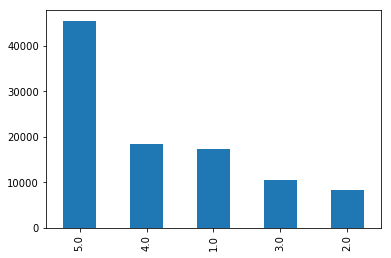

In [25]:
#Plot the distribution of overall ratings
#From the plot below the distribution of star ratings can be seen which shows that majority of 
#products have 5 star ratings so if we build a model solely by taking star rating into consideration for 
#a specific user then it is going to be biased


df_reviews['overall'].value_counts().plot(kind='bar')

In [26]:
df_reviews['reviewText'].to_csv('textreview.txt',sep=' ', index=False, header=False)

In [27]:

text = open("textreview.txt",'r').read()

In [28]:
cleaned = nltk.word_tokenize(text.lower())

In [29]:
type(cleaned)

list

In [30]:
#This is required to create a list of words having more than 2 characters in them and the idea is to prepare the 
#input for WordCloud function so that it can count and group words to be sorted in descending order of frequency so that larger words in wordcloud are the ones which appear most in review and the smaller the word the lesser frequent it will be .

wordlist = [x for x in cleaned if (len(x)>=2 and x.isalpha())]

In [31]:
#This is going to print the wordcloud from the list created above

wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white').generate(" ".join(wordlist))

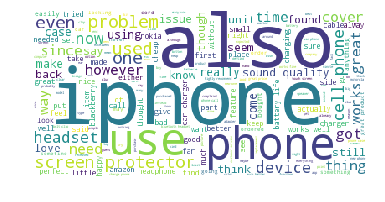

In [32]:
# Open a plot of the generated image.
#Below is the word cloud meaning the word with highest size has been used most number of times 
#and just by taking a look at the word cloud we can say that the data corresponds to cellphones and accessories

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [33]:
# Which ASIN has attracted most number of reviews and what is its average overall rating

print("\nMost Reviewed Product in the dataset :",df_reviews['asin'].value_counts().idxmax())
print("\nNumber of reviews: ",df_reviews['asin'].value_counts().max())




Most Reviewed Product in the dataset : B002BH3I9U

Number of reviews:  2898


In [34]:
## Embed the  hyperlink in the notebook 

from IPython.core.display import display, HTML
print("\nMost Reviewed Product in Cellphone and Accessories")
display(HTML("<a href='https://www.amazon.com/dp/B002BH3I9U' target='_blank'>https://www.amazon.com/dp/B002BH3I9U</a>"))


Most Reviewed Product in Cellphone and Accessories


In [35]:
## Reviewer providing the Most number of reviewsfor a product the dataset

print("\nReviewer providing the most number of Reviews :",df_reviews['reviewerID'].value_counts().idxmax())
print("\nNumber of reviews: ",df_reviews['reviewerID'].value_counts().max())



Reviewer providing the most number of Reviews : A2WLNSZ9U0T1S3

Number of reviews:  15


In [36]:
#polarity -  a measure of the negativity, the neutralness, or the positivity of the text
#number of words per review
#number of sentences per review
#subjectivity - Return the subjectivity score as a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.
#sentence_complexity - is a measure that we are calculating

def create_textblob_features():
    
    
    df_reviews['polarity'] = df_reviews['reviewText'].map(lambda x: TextBlob(x).sentiment.polarity)
    df_reviews['subjectivity'] = df_reviews['reviewText'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
    df_reviews['words_per_sentence'] = df_reviews['word_length'] / df_reviews['sentence_length']
    df_reviews['sentence_complexity'] = df_reviews['reviewText'].apply(lambda x: float(len(set(TextBlob(x).words))) / float(len(TextBlob(x).words)))

In [37]:
create_textblob_features()

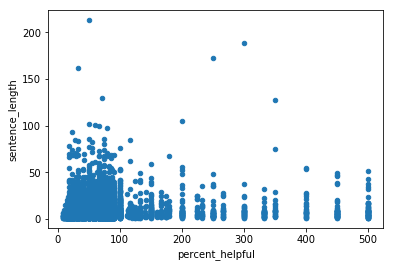

In [38]:

#This plot shows the comparison of number of sentences in the  review against the percent helpfulness of the review
#Below plot shows the percentage of how many reviews are helpful as indicated by the dataset against the sentence 
#length of the review. 
#It can be clearly seen that the length of the review does not directly guarantee the helpfulness of the review. 
#Infact smaller sentences appear to be more helpful as can be seen by the high density of data points towards the lower
#left hand side of the graph.


df_reviews.plot(kind='scatter', x='percent_helpful', y='sentence_length')

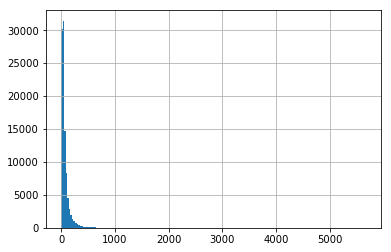

In [39]:
## This histogram shows the distribution of number  of words used in  reviews
#Below graph shows the average number of words used per review and we see there are some 
#reviews which have a significant higher number of words which skew the distribution towards the right but 
#against those reviews the helpfulness does not come out to be significant as was seen when building the model.

df_reviews.word_length.hist(bins=200)

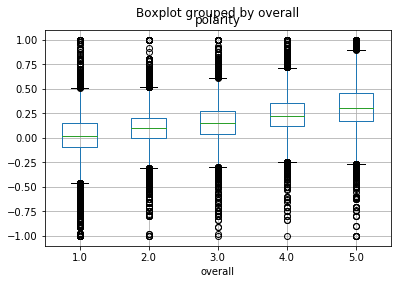

In [40]:
# Box plot to show the polarity of reviews against overall ratings
#Below plot shows the polarity (sentiment score ) of the reviews against overall ratings and as expected for 
#higher ratings the median polarity and max polarity and min polarity are higher.

df_reviews.boxplot('polarity', 'overall')